In [ ]:
pip install node2vec

In [ ]:
pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import node2vec

import torch
import torch_geometric as tg

from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split

## Read Data

In [ ]:
SPAM_EDGES = None
SPAM_LABELS = None

with open('BZR-MD.edges') as edges_file:
    SPAM_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=',')

with open('BZR-MD.node_labels') as nodes_file:
    SPAM_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    SPAM_LABELS = SPAM_LABELS[:, 1]

## Data Preprocessing

In [ ]:
X = SPAM_EDGES
Y = SPAM_LABELS

In [ ]:
G = nx.DiGraph()
G.add_edges_from(X)
print(f"G has node: {G.number_of_nodes()} and edges: {G.number_of_edges()}")

G has node: 6519 and edges: 137734


In [ ]:
EPOCHS = 1000
NUM_NODES = np.max(X)
NUM_CLASSES_CLUSTERS = np.max(Y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data = tg.data.Data(
    x=torch.eye(NUM_NODES),
    edge_index=torch.tensor(X-1, dtype=torch.long).t().contiguous(),
    y=torch.nn.functional.one_hot(torch.tensor(Y-1, dtype=torch.long), NUM_CLASSES_CLUSTERS)).to(device)
    # y=torch.tensor(Y-1, dtype=torch.long)).to(device)

In [ ]:
adjacency_matrix = np.zeros((NUM_NODES, NUM_NODES))
adjacency_matrix[X[:, 0]-1, X[:, 1]-1] = 1
adjacency_matrix[X[:, 1]-1, X[:, 0]-1] = 1

## Fully Connected Neural Network

In [ ]:
class FCN(torch.nn.Module):
    def __init__(self, num_nodes, num_classes):
        super(FCN, self).__init__()
        self.fc1 = torch.nn.Linear(num_nodes, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
model_fcn = FCN(NUM_NODES, NUM_CLASSES_CLUSTERS).to(device)
optimizer_fcn = torch.optim.Adam(model_fcn.parameters(), lr=0.01)
loss_fn_fcn = torch.nn.CrossEntropyLoss()

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(adjacency_matrix, Y, test_size=0.2, random_state=42)
X_TRAIN = torch.tensor(X_TRAIN, dtype=torch.float).to(device)
X_TEST = torch.tensor(X_TEST, dtype=torch.float).to(device)
Y_TRAIN = torch.nn.functional.one_hot(torch.tensor(Y_TRAIN-1, dtype=torch.long)).to(device)
Y_TEST = torch.nn.functional.one_hot(torch.tensor(Y_TEST-1, dtype=torch.long)).to(device)

In [ ]:
loss_list_fcn = []
acc_list_fcn = []

for epoch in range(EPOCHS):
    model_fcn.train()
    optimizer_fcn.zero_grad()
    out = model_fcn(X_TRAIN)
    loss = loss_fn_fcn(out, Y_TRAIN.float())
    loss.backward()
    optimizer_fcn.step()

    model_fcn.eval()
    _, pred = model_fcn(X_TEST).max(dim=1)
    correct = float(pred.eq(Y_TEST.float().argmax(dim=1)).sum().item())
    acc = correct / len(Y_TEST)
    if (epoch+1) % 100 == 0:
        print('Epoch: {:03d}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch+1, loss, acc))

    loss_list_fcn.append(loss.item())
    acc_list_fcn.append(acc)

Epoch: 100, Loss: 1.50929, Acc: 0.77454
Epoch: 200, Loss: 1.50929, Acc: 0.77454
Epoch: 300, Loss: 1.50929, Acc: 0.77454
Epoch: 400, Loss: 1.50929, Acc: 0.77454
Epoch: 500, Loss: 1.50929, Acc: 0.77454
Epoch: 600, Loss: 1.50929, Acc: 0.77454
Epoch: 700, Loss: 1.50929, Acc: 0.77454
Epoch: 800, Loss: 1.50929, Acc: 0.77454
Epoch: 900, Loss: 1.50929, Acc: 0.77454
Epoch: 1000, Loss: 1.50929, Acc: 0.77454


In [ ]:
# test the model
model_fcn.eval()
_, pred = model_fcn(X_TEST).max(dim=1)
correct = float(pred.eq(Y_TEST.argmax(dim=1)).sum().item())
acc = correct / len(data.y)
print('Test Accuracy: {:.5f}'.format(acc))

Test Accuracy: 0.15493


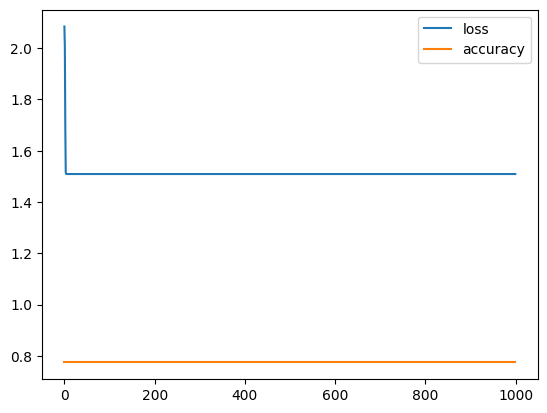

In [ ]:
# plot loss and accuracy
plt.plot(loss_list_fcn)
plt.plot(acc_list_fcn)
plt.legend(['loss', 'accuracy'])
plt.show()

## Graph Convolutional Network with 2 fully connected layers

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, 1024)
        self.conv2 = tg.nn.GCNConv(1024, 256)
        self.conv3 = tg.nn.GCNConv(256, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        # x = torch.nn.functional.relu(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [ ]:
model_gcn = GCN(num_node_features=NUM_NODES, num_classes=NUM_CLASSES_CLUSTERS).to(device)
optimizer_gcn = torch.optim.Adam(model_gcn.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn_gcn = torch.nn.CrossEntropyLoss()

In [ ]:
loss_list_gcn = []
accuracy_list_gcn = []

for epoch in range(EPOCHS):
    model_gcn.train()
    optimizer_gcn.zero_grad()
    out = model_gcn(data)
    loss = loss_fn_gcn(out, data.y.float())
    loss.backward()
    optimizer_gcn.step()

    # validate the model
    model_gcn.eval()
    _, pred = model_gcn(data).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred.eq(true_labels).sum().item())
    acc = correct / len(data.y)
    loss_list_gcn.append(loss.item())
    accuracy_list_gcn.append(acc)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:03d}\t Loss: {loss:.4f}\t Val Acc: {acc:.4f}')

Epoch: 100	 Loss: 1.5073	 Val Acc: 0.7667
Epoch: 200	 Loss: 1.5077	 Val Acc: 0.7667
Epoch: 300	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 400	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 500	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 600	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 700	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 800	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 900	 Loss: 1.5075	 Val Acc: 0.7667
Epoch: 1000	 Loss: 1.5075	 Val Acc: 0.7667


In [ ]:
# test the model
model_gcn.eval()
_, pred = model_gcn(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print(f'Test Acc: {acc:.4f}')

Test Acc: 0.7667


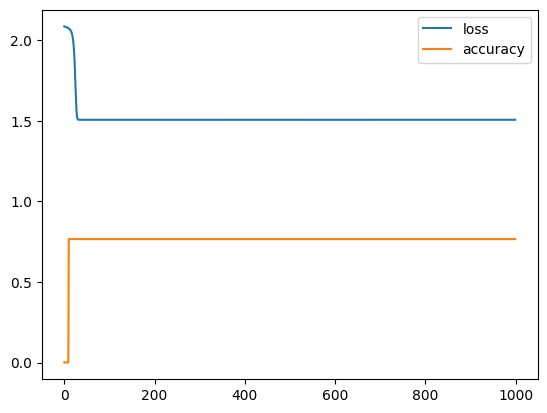

In [ ]:
# plot loss and accuracy
plt.plot(loss_list_gcn)
plt.plot(accuracy_list_gcn)
plt.legend(['loss', 'accuracy'])
plt.show()

## Graph Encoder Embedding

In [ ]:
class GraphEncoderEmbedding(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GraphEncoderEmbedding, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_features, 256)
        self.conv2 = tg.nn.GCNConv(256, num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

In [ ]:
class LDA(torch.nn.Module):
    def __init__(self):
        super(LDA, self).__init__()

    def forward(self, X, y):
        n_features = X.shape[1]
        class_labels = torch.unique(y)
        mean_vectors = [torch.mean(X[y == cl], dim=0) for cl in class_labels]
        S_W = torch.zeros((n_features, n_features))
        for cl, mean_vec in zip(class_labels, mean_vectors):
            class_sc_mat = torch.zeros((n_features, n_features))
            for row in X[y == cl]:
                row, mean_vec = row.reshape(n_features, 1), mean_vec.reshape(n_features, 1)
                class_sc_mat += (row - mean_vec).dot((row - mean_vec).T)
            S_W += class_sc_mat
        overall_mean = torch.mean(X, dim=0)
        S_B = torch.zeros((n_features, n_features))
        for mean_vec in mean_vectors:
            n = X[y == cl].shape[0]
            mean_vec = mean_vec.reshape(n_features, 1)
            overall_mean = overall_mean.reshape(n_features, 1)
            S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
        eig_vals, eig_vecs = torch.eig(torch.inverse(S_W).matmul(S_B), eigenvectors=True)
        eig_pairs = [(torch.abs(eig_vals[i, 0]), eig_vecs[:, i]) for i in range(len(eig_vals))]
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
        W = torch.stack([eig_pairs[i][1] for i in range(len(class_labels) - 1)], dim=1)
        return W

In [ ]:
model = GraphEncoderEmbedding(num_features=NUM_NODES, num_classes=NUM_CLASSES_CLUSTERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

NameError: ignored

In [ ]:
loss_list = []
accuracy_list = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.y.float())
    loss.backward()
    optimizer.step()

    # validate the model
    model.eval()
    _, pred = model(data.x, data.edge_index).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred.eq(true_labels).sum().item())
    acc = correct / len(data.y)
    loss_list.append(loss.item())
    accuracy_list.append(acc)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:03d}\t Loss: {loss:.4f}\t Val Acc: {acc:.4f}')

In [ ]:
# test the model
model.eval()
_, pred = model(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print(f'Test Acc: {acc:.4f}')

In [ ]:
# plot loss and accuracy
plt.plot(loss_list)
plt.plot(accuracy_list)
plt.legend(['loss', 'accuracy'])
plt.show()

## Spectral Embedding

In [ ]:
embedding = SpectralEmbedding(n_components=NUM_NODES-10)  # 2D embedding
spectral_embedding = embedding.fit_transform(adjacency_matrix, Y)

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(spectral_embedding, Y, test_size=0.2, random_state=42)

In [ ]:
lda_spectral = LinearDiscriminantAnalysis()
lda_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_LDA_SPECTRAL = lda_spectral.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_LDA_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_LDA_SPECTRAL)}")

print()
print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda_spectral.predict(X_TEST))}")

Training Accuracy LDA:
Accuracy: 0.9963566634707575
Adjusted Rand Index: 0.9900217203426217

Testing Accuracy LDA:
Accuracy: 0.06288343558282208
Adjusted Rand Index: -0.019357957466594227


In [ ]:
qda_spectral = QuadraticDiscriminantAnalysis()
qda_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_QDA_SPECTRAL = qda_spectral.predict(X_TRAIN)

print("Training Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_QDA_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_QDA_SPECTRAL)}")

print()
print("Testing Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TEST == qda_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, qda_spectral.predict(X_TEST))}")

LinAlgError: ignored

In [ ]:
kmeans_spectral = KMeans(n_clusters=NUM_CLASSES_CLUSTERS)
kmeans_spectral.fit(X_TRAIN)
Y_PRED_KMEANS_SPECTRAL = kmeans_spectral.predict(X_TRAIN)

print("Training Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TRAIN-1 == Y_PRED_KMEANS_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN-1, Y_PRED_KMEANS_SPECTRAL)}")

print()
print("Testing Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TEST-1 == kmeans_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST-1, kmeans_spectral.predict(X_TEST))}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training Accuracy KMeans:
Accuracy: 0.763758389261745
Adjusted Rand Index: 0.0004395503212008304

Testing Accuracy KMeans:
Accuracy: 0.7745398773006135
Adjusted Rand Index: 0.0


In [ ]:
svm_spectral = SVC()
svm_spectral.fit(X_TRAIN, Y_TRAIN)
Y_PRED_SVM_SPECTRAL = svm_spectral.predict(X_TRAIN)

print("Training Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_SVM_SPECTRAL) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_SVM_SPECTRAL)}")

print()
print("Testing Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TEST == svm_spectral.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, svm_spectral.predict(X_TEST))}")

Training Accuracy SVM:
Accuracy: 0.8797698945349952
Adjusted Rand Index: 0.5511948075407224

Testing Accuracy SVM:
Accuracy: 0.7745398773006135
Adjusted Rand Index: 0.0


## Node2Vec

In [ ]:
node2vec_model = node2vec.Node2Vec(G, dimensions=NUM_NODES-10, num_walks=200, workers=4)

model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv

node_ids = list(G.nodes())  # List of nodes in the graph
embedding_matrix = np.array([model.wv[str(node_id)] for node_id in node_ids])

Computing transition probabilities:   0%|          | 0/6519 [00:00<?, ?it/s]

In [ ]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(embedding_matrix, Y, test_size=0.2, random_state=42)

In [ ]:
lda_node = LinearDiscriminantAnalysis(n_components=2)
lda_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_LDA_NODE = lda_node.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_LDA_NODE) / len(Y)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_LDA_NODE)}")\

print()
print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda_node.predict(X_TEST))}")

In [ ]:
qda_node = QuadraticDiscriminantAnalysis()
qda_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_QDA_NODE = qda_node.predict(X_TRAIN)

print("Training Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_QDA_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_QDA_NODE)}")

print()
print("Testing Accuracy QDA:")
print(f"Accuracy: {np.sum(Y_TEST == qda_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, qda_node.predict(X_TEST))}")

In [ ]:
kmeans_node = KMeans(n_clusters=NUM_CLASSES_CLUSTERS)
kmeans_node.fit(X_TRAIN)
Y_PRED_KMEANS_NODE = kmeans_node.predict(X_TRAIN)

print("Training Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TRAIN-1 == Y_PRED_KMEANS_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN-1, Y_PRED_KMEANS_NODE)}")

print()
print("Testing Accuracy KMeans:")
print(f"Accuracy: {np.sum(Y_TEST-1 == kmeans_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST-1, kmeans_node.predict(X_TEST))}")

In [ ]:
svm_node = SVC()
svm_node.fit(X_TRAIN, Y_TRAIN)
Y_PRED_SVM_NODE = svm_node.predict(X_TRAIN)

print("Training Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TRAIN == Y_PRED_SVM_NODE) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, Y_PRED_SVM_NODE)}")

print()
print("Testing Accuracy SVM:")
print(f"Accuracy: {np.sum(Y_TEST == svm_node.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, svm_node.predict(X_TEST))}")